# Arbitrage and Risk-Neutral Pricing
#### Roland Grinis

In [ ]:
import torch
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

## 1 Introduction

### 1.1 What are *derivatives*?

Assets include bonds, stocks, commodities, FX rates, cryptocurrencies etc. 

Some examples:

#### 1.1.1 Zero-coupon bond
A contract worth $P(t,T)$ at time $t$ that pays $P(T,T) = 1$ at maturity $t=T$

In [2]:
nday = 365 # Actual/365 day counting convention
t = torch.linspace(0,1,nday) # in years, maturity T = 1
time_to_maturity = 1 - t

Continuously-compounded spot interest rate 
$$
r(t,T) = - \frac{\log P(t,T)}{T-t}
$$

In [3]:
spot_interest_rate = 0.01 * torch.rand(nday) + 0.05 * torch.sigmoid(100 * (t-0.5))  # rate hike
bond = torch.exp(- time_to_maturity * spot_interest_rate)

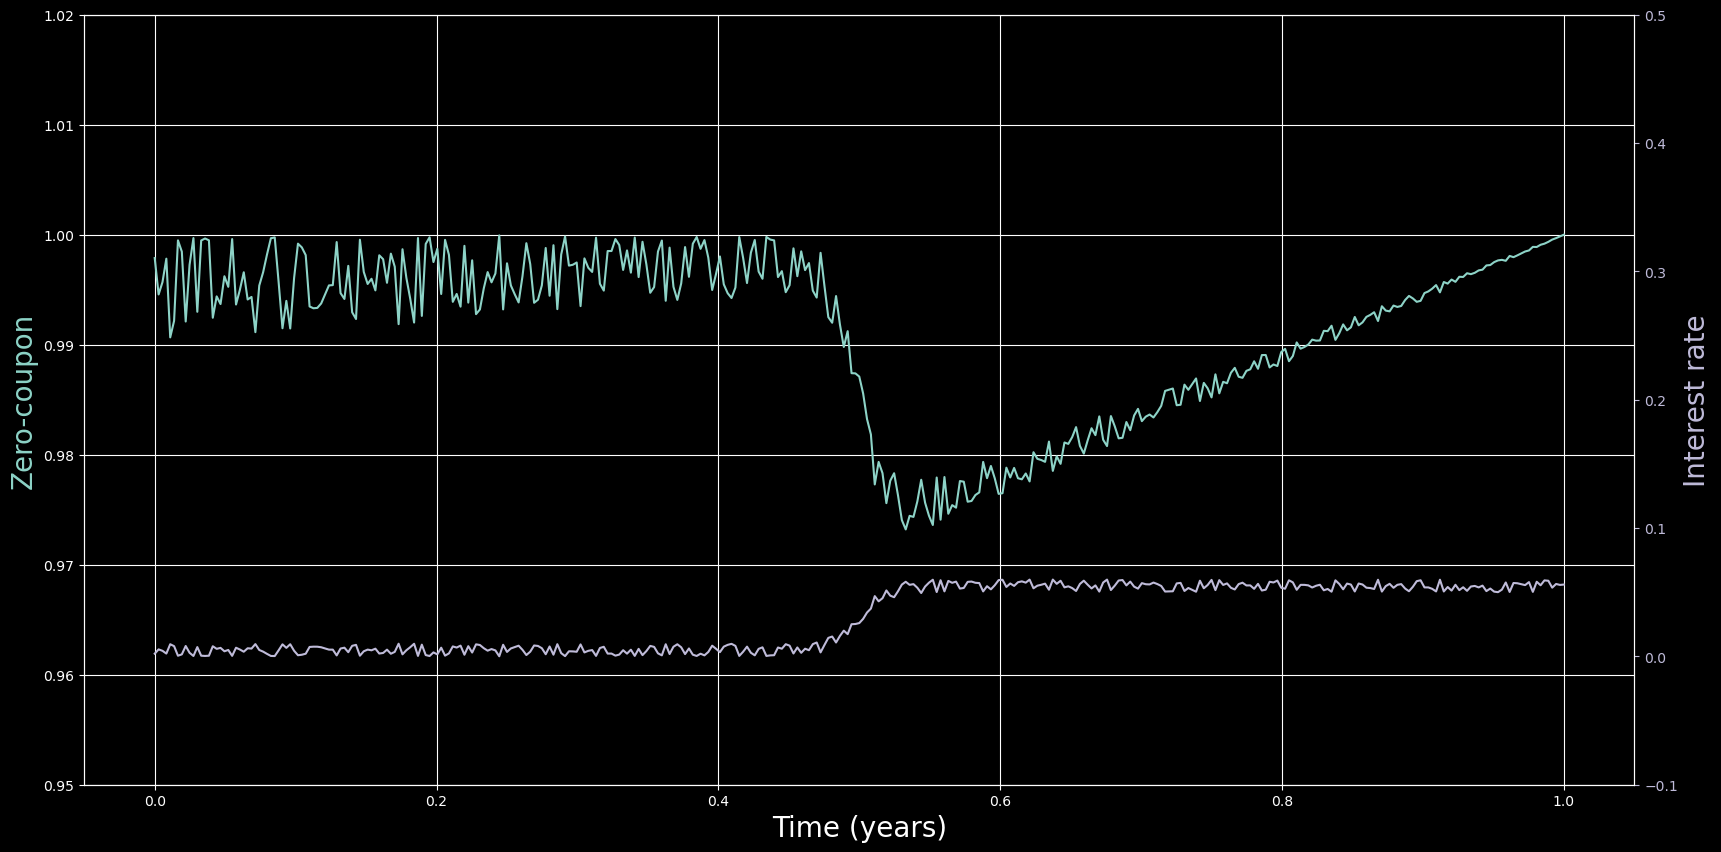

In [4]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('Time (years)', color='white', fontsize=20)
ax1.set_ylabel('Zero-coupon', color='C0', fontsize=20)
ax1.plot(t.numpy(), bond.numpy(), 'C0')
ax1.set_ylim([0.95,1.02])
ax1.grid(True)

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=20)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### 1.1.2 Zero-bond curve 
This is the map:

$$
T \rightarrow P(t,T), \quad T>t
$$ 

with corresponding continuously-compounded zero-coupon curve:

$$
T \rightarrow r(t,T), \quad T>t
$$ 

sometimes simply referred to as the *yield curve*. 

There are many different curves, e.g.
[US Libor](https://tradingeconomics.com/united-states/interbank-rate),
[US Treasuries](https://tradingeconomics.com/united-states/government-bond-yield) etc. Those are based on governement bonds, and there are considered as risk-free. But many other entities can also issues bonds. 

The curve is said to be *flat* if the rate does not depend on maturity:
$$
r(t, T) = r(t,t), \quad \forall T>t
$$


#### 1.1.3 Risky assets
Stock prices $S(t)$ and everything else is classified as *more risky*. At the beginning of 20th century Bachelier proposed to model them as Brownian motion:

In [5]:
dt = torch.cat((torch.zeros(1), t.diff()))
K = 100
drift = 0.8
vol = 1.2
Y = ((drift - 0.5*vol**2)*dt + vol*torch.randn(nday) * torch.sqrt(dt)).cumsum(0) 
S = K * torch.exp(Y)

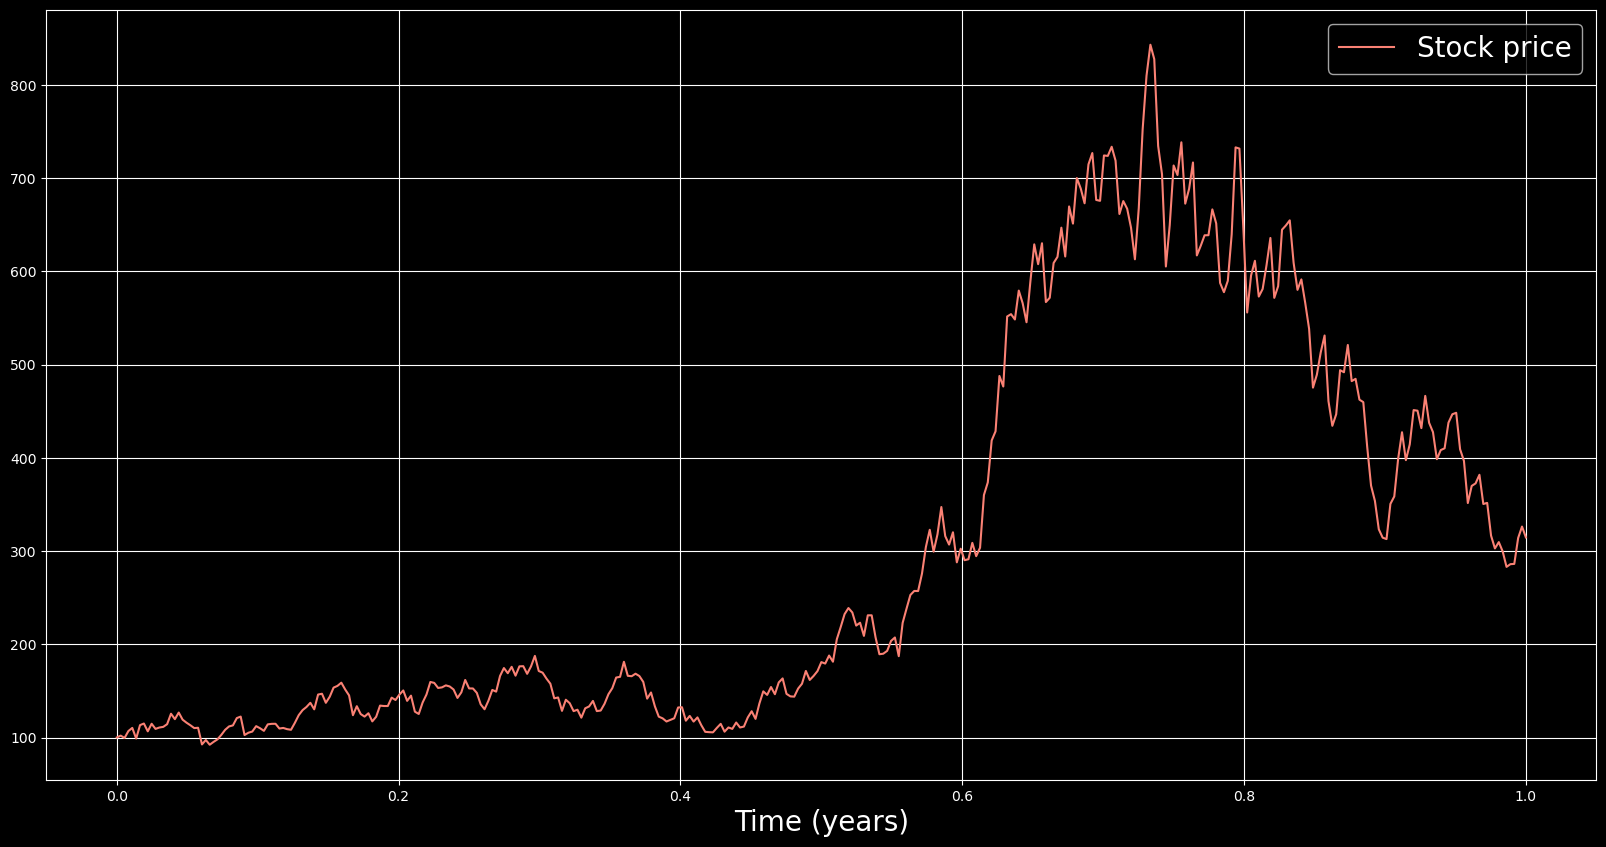

In [6]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.legend(fontsize=20)
plt.xlabel('Time (years)', color='white', fontsize=20)
plt.grid()
plt.show()

Mandelbrot noted in the 1960s that Brownian motion fails to produce *fat tails* typically observed in stock returns distribution. Modelling improvements include *stochastic volatility* and *jump processes*.

#### 1.1.5 Financial Derivatives
It is a contract between a party (or a holder) and its counter-party (or the writer) entered at time $t=t_0$ and settleted:
* at maturity $t=T$ (European style)
* at any time $t \leq T$ (American style)
* at some specified exercise dates $t_1, t_2, \dots, T$ (Bermudan style)

according to a *payoff* function that depends on one or several underlying financial instruments or indices (assets, or other derivatives). 

The payoff might depend on the value of the underlyings at exercise date (vanilla contracts) or on the whole path between $t_0$ and maturity $T$ (exotic contracts).

The contract might be **physically-settled** when the ownership of the underlying instrument is transferred to the holder of the contract according to the payoff and if the instrument is tradeable. In many cases though, the contract is **cash-settled** where the value of the payoff is settled in a predetermined currency. 

Derivatives can be traded directly between parties, those are *over-the-counter* (OTC) contracts, or via a Central Counter Party (CCP), e.g. on an exchange such as CME, or a clearing house like the LCH.  

Examples:

#### 1.1.6 Forwards/Futures

A *forward* is an OTC contract that obliges the holder, at time $t$, to buy the security $S_t$ from the writer at some future maturity time $T>t$ for a price $F(t,T)$ called the *forward rate*. The payoff at maturity is:
$$
\mathcal{P}_F(S_T) = S_T - K
$$
By definition $F(t,T)$ is chosen such that the value of the contract at time $t$ is trivial.

*Futures* are exchange traded standardized versions of forwards. 

##### Example: Leveraged Trading
Forwards/futures fixe the physical delivery of the underlying asset at maturity. They are traded on margin (see next section) and are typically used to gain leverage. 


#### 1.1.6.1  Forwards/Futures yield curve
We define the (continuously compounded) *forward (futures) yield to maturity* $r_f$ such that:
$$
F(t,T) = \frac{S_t}{e^{- r_f\cdot(T-t)}}
$$
Note that $r_f = r_f(t,T)$ depends on time to maturity. The map:
$$
T \rightarrow r_f(t,T), \quad T>t
$$
is called the forward (futures) yield curve. 

##### Examples
In these examples, the zero coupon $P(t,T)$, with continuously compounded rate $r(t,T)$, stands for the most riskless bond in a given currency. Typically, those bonds are the government bonds.
* if $S_t$ is a financial instrument that is not defaultable and does not admit debit or credit cashflows (e.g. a stock of a blue chip company that does not pay dividents) then:
$$
r_f(t,T) \equiv  r(t,T) \quad \text{the governement bonds rate}
$$
* if $S_t$ is a stock paying dividends $d \geq 0$, with $\lambda$ its probability to default (that's basically the credit default swap (CDS) rate), all modelled via continuous compounding then:
$$
r_f(t,T) \equiv  r(t,T) - d(t,T) + \lambda(t,T) 
$$
* if $S_t$ is an FX (or crypto) rate, with $r$ and $r_F$ the domestic and foreign interest governemnt bonds rates, and $b$ is the cross-currency basis swap rate XCCY (that's the probability that the foreign governemnt defaults, while the domestic stays) then:
$$
r_f(t,T) \equiv  r(t,T) - r_F(t,T) + b(t,T) 
$$

#### 1.1.6.2  Commodities Futures

For commodities, the above framework is not quite general enough. In fact:
$$
F(t,T) = \frac{S_t + C_t}{e^{- r\cdot(T-t)}}
$$
where $C_t$ is the *cost of carry*. In pratice, that could give negative futures which famously happened in April 2020 during the pandemic for U.S. crude oil.



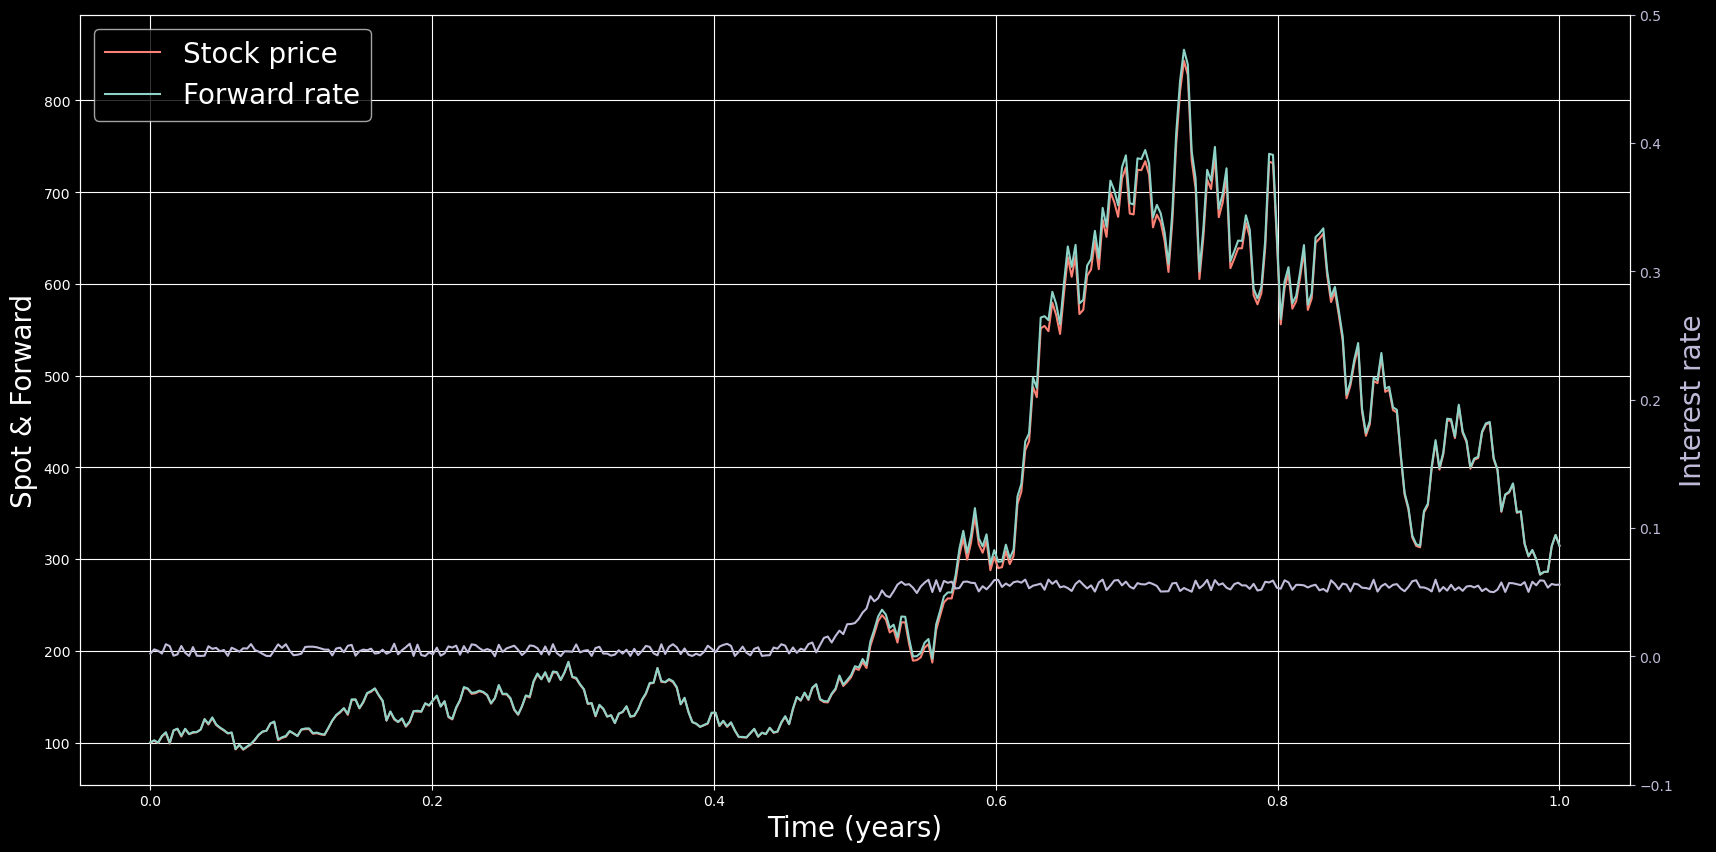

In [7]:
F = S / bond 
m = F.max()

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('Time (years)', color='white', fontsize=20)
ax1.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
ax1.plot(t.numpy(), F.numpy(), 'C0', markersize=30, label='Forward rate')
ax1.set_ylabel('Spot & Forward', fontsize=20)
ax1.legend(loc='upper left',fontsize=20)
ax1.grid(True)

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=20)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### 1.1.7 Swaps

An *interest rate swap* is a contract that obliges the holder (also called the receiver) to exchange with the writer (also called the payer) floating rate payments to be made at dates $\mathcal{T} = \{ T_0,T_1,\dots,T_n\}$ for a fixed *forward swap rate*:
$$
S_{\mathcal{T}}(t) = \frac{P(t,T_0) - P(t,T_n)}{A_{\mathcal{T}}(t)}
$$
where 
$$
A_{\mathcal{T}}(t) = \sum_{i=1}^{n}\tau_iP(t,T_i), \quad \tau_i = T_i - T_{i-1}
$$
is the *swap annuity*.

##### Example: Fixing Interest Rate
Swaps are used to convert an existing loan from floating payments to a fixed rate. 

#### 1.1.8 Options
Forwards and swaps are example of *linear* products. Options represent another class of derivatives whose value depends non-linearly on the price of the underlying.  

A *call option* gives the right to the holder (but not the obligation) to buy a security $S_{t_e}$ at an exercise date $t_e$ for a fixed price $K$, *the strike*. The payoff $\mathcal{P}_C$ is given by:
$$
\mathcal{P}_C(S_{t_e}) = (S_{t_e} - K)^{+} = \max\{S_{t_e} - K,0\}
$$
A *put option* gives the right (but not the obligation) to sell a security $S_{t_e}$ at an exercise date $t_e$ for the strike $K$. The payoff in this case is:
$$
\mathcal{P}_P(S_{t_e}) = (K - S_{t_e})^{+} 
$$ 

#####  Example: Covered Call

Put options are popular for hedging against a sudden drop in the value of an investement in a risky asset. 

A typically strategy is the *covered call*: an investor holding a risky asset $S_t$ that appreciated in value wants to profit from further increase over $[t,T]$, but needs to protect from a potential downside risk. She proceeds buying an OTM put at strike $K_p<S_t$ financing the purchase by writing an OTM call with suitable strike $K_c > S_t$.

At time $T$, she can close extra profit for:
$$
K_c - S_t, \quad \text{if} \quad S_T \geq K_c,
$$
and in the worse case scenario she would lose:
$$
S_t - K_p, \quad \text{if} \quad S_T \leq K_p,
$$

In [13]:
td = int(nday*0.75)
St = S[td]
Kc = int((1+0.25*vol)*St)
Kp = int((1-0.25*vol)*St)
tT = t[td:]

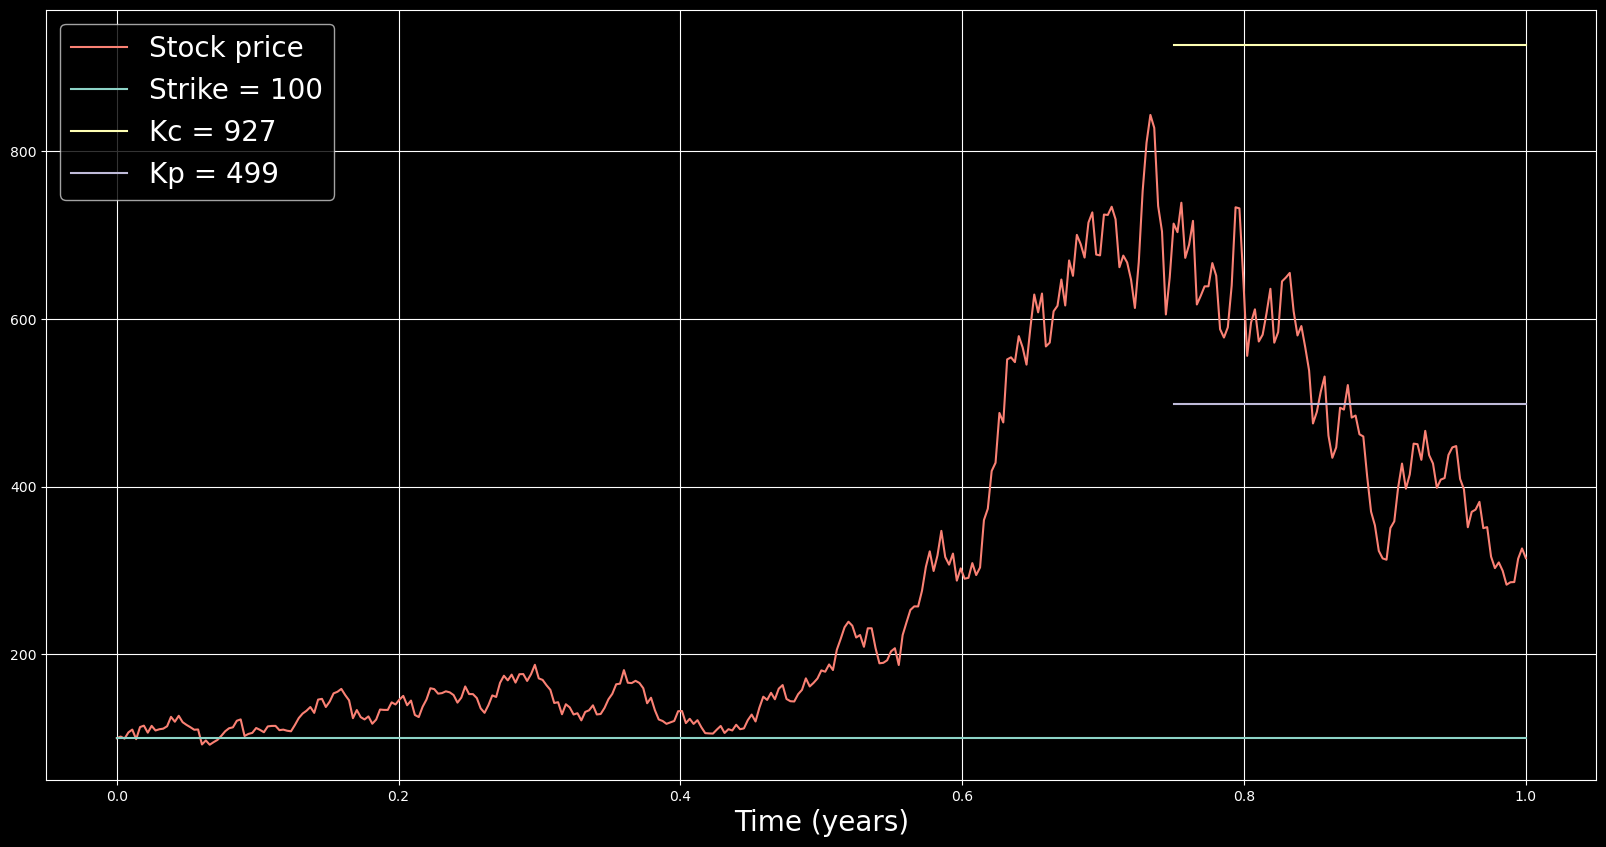

In [14]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.plot(t.numpy(), K*torch.ones_like(S).numpy(),'C0',markersize=30, label=f'Strike = {K}')
plt.plot(tT.numpy(), Kc*torch.ones_like(tT).numpy(),'C1',markersize=30, label=f'Kc = {Kc}')
plt.plot(tT.numpy(), Kp*torch.ones_like(tT).numpy(),'C2',markersize=30, label=f'Kp = {Kp}')
plt.legend(fontsize=20)
plt.xlabel('Time (years)', color='white', fontsize=20)
plt.grid(True)
plt.show()

#### 1.1.9 Moneyness 
If the forward rate is equal to the strike, $F(t,T) = K$, we say that the option is *at-the-money* (ATM). For a call:
* if $K < F(t,T)$ the option is *in-the-money* (ITM)

* if $K > F(t,T)$ the option is *out-of-the-money* (OTM)

For a put it's the other way round. 

#### 1.1.10 Swaptions
A *receiver swaption* gives the right (but not the obligation) to enter a swap where the floating rate payments will be exchanged for a fixed rate $K$. It is essentially a call option on the forward swap rate $S_{\mathcal{T}}(t)$ with strike $K$. 

A *payer swaption* gives the right (but not the obligation) to enter a swap as a payer, where a fixed rate $K$ will be exchanged for floating rate payments. It is a put option on $S_{\mathcal{T}}(t)$.

*Callables* are popular products that combine a swap together with an ATM Bermudan payer swaption enabling the holder to get out of fixed rate payements if the interest rates fall.


#### 1.1.11 Securities
By a slight abuse of terminology, we will use the term *security* and *financial instrument* interchangeably to refer to any tradeable asset, contract or derivative.

### 1.2 How derivative contracts are traded?

The answer is easy: it is *always* the market that settles to a value for a derivative contract as a result of *demand and supply* dynamics. 

However, in some situations (especially for linear payoffs), the value of a derivative can be directly derived from the price of other securities. 

#### 1.2.1 Why do we need models?

Nowdays, derivatives are traded on margin. When a party and a counter-party enter a trade, only a certain percent of the contract value is exchanged: the *variation margin*. 

Each party then deposits funds that should cover the *initial margin*: this is the potential depreciation in the value of the contract due to moves in the market, and also account for the possiblity of counter-party default. This is based on sensitivity calculations for the value of the derivative which requires modelling.

If a party incurs a loss which eats deep into the initial margin down to a level called the *maintenance margin*, the party will have to give away its losses and close the trade, or deposit more funds (this is called a *margin call* for exchange traded derivatives). But since the latest Basel agreements, due to the downfall of Lehman Brothers in 2008, those strict rules also concern the OTC market.

Moreover, the regulators require that the overall portfolio of large banks has small sensitivity to market movements, i.e. it is *market neutral*, and is well diversified. 


#### 1.2.2 Who are the *quants*?

Front office: 
* quant traders
* strategist (strats)
* quant modellers 
* quant developers

Back office:
* risk management
* regulatory 

## 2 Diffusion processes

### 2.1 Wiener Process (Brownian motion)

* Let $(\Omega, \mathbb{P})$ be a probability space with time filtration $\mathcal{F} = \left( \mathcal{F}_t\right) $ - events in $\mathcal{F}_t$ have only been realised up to time $t$.

* For each realisation of an event $\omega \in \Omega$, suppose there is a trajectory $t \rightarrow W(t)$ that depends on $\omega$, that's called a *stochastic process*. 

* If $W(t)$ depends only events from $\mathcal{F}_t$, that is only events realised up to time $t$ and not from the future beyond $t$, we say $W$ is $\mathcal{F}$-*adapted*.

* If the probability distribution $\mathbb{P}\left[ W(T) | \mathcal{F}_t \right]$ of $W(T)$ conditional on events from $\mathcal{F}_t$ depends only $W(t)$ for any $T>t$, we say $W$ is *Markov*. 

* If the conditional expectation $\mathbb{E} \left[ W(T) | \mathcal{F}_t \right] = W(t)$, we say $W$ is *Martingale*.

* We call $W(t), t \geq 0$, a *Brownian motion* if for all $t_i;\ (i = 0,1...n)$ the increments $ \delta W\left(t_i\right)=W\left(t_i\right)-W\left(t_{i-1}\right) $ are independent normally distributed $N(\mu, \sigma^2)$ with
$$
\begin{aligned}
\mu = \mathbb{E}\left[W\left(t_{i+1}\right)-W\left(t_i\right)\right] &=0 \\
\sigma^2 =\mathbb{E}\left[\left( W\left(t_{i+1}\right)-W\left(t_i\right)\right)^2\right] = \operatorname{Var}\left[W\left(t_{i+1}\right)-W\left(t_i\right)\right] &=t_{i+1}-t_i
\end{aligned}
$$

and $W(0) = 0$. It is Markov and Martingale by definition.

In [24]:
# creating brownian motion
torch.manual_seed(41)
sigma = torch.tensor(0.25)
Wt = torch.cumsum(sigma * t.diff().sqrt().reshape((1, nday - 1)) * torch.randn((nday-1)), 1)
minimum = torch.min(Wt) * torch.ones(3)
maximum = torch.max(Wt) * torch.ones(3)
vlines = [120,200,280]
Wt_ = Wt.numpy()[0,:]

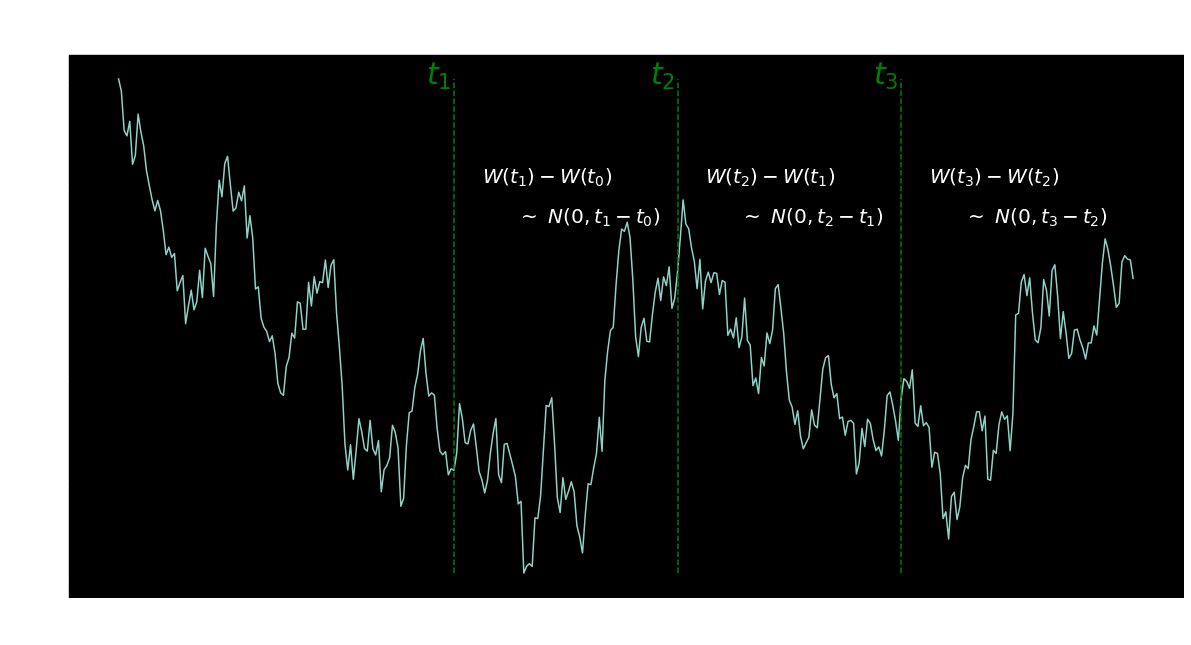

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(Wt_)
plt.xlabel('Time index', color='white', fontsize=20)
plt.ylabel('W(t)', color='white', fontsize=20)
plt.title('Brownian motion:'+' '*10+'$\lim_{n \\to \infty} W^{(n)}(t) \sim N(0,t)$' + ' '*10 + '$\mathbb{E}[W(t_{i+1}) | \mathcal{F}]=W(t_{i}) $', fontsize=28)
for i in (0,1,2):
    plt.text(vlines[i]-10, 0, f'$t_{i+1}$', fontsize = 30, color = 'green')
    plt.text(vlines[i]+10, -0.05, f'$W(t_{i+1})-W(t_{i})$', fontsize = 20, color = 'white')
    plt.text(vlines[i]+20, -0.07, f'$\ \sim \ N(0, t_{i+1} - t_{i})$', fontsize = 20, color = 'white')
plt.vlines(vlines, ymin= minimum,ymax = maximum, color = 'green', linestyles='--')
plt.show()

### 2.2 Ito Integral

If we try to integrate a normal continuous function $b(t)$ with respect to Brownian Motion $W(t)$, the definition of such Integral $X=I(t)=\int_0^t b(\tau) d W(\tau) \\  $ is required.

Firstly divide the interval of integration to $N$ parts $ (t_1, t_2), ..., (t_{N-1}, t_N)$ and denote 
$$
I_N \left[ b(t) \right] = \sum_{i=0}^{N-1} b(t_{i-1}) \left( W_{t_i} - W_{t_{i-1}} \right) 
$$
Ito has proved that there is a function $ I[b(t)] = \int_0^t b(\tau) d W(\tau)$ such that
$$
\mathbb{E}\left[ \left( I[b(t) \right] - I_N \left[ b(t) \right] \right)^2] \rightarrow\ 0\ as\ N \rightarrow \inf
$$
This function is called Ito Integral and it has following properties:

+ (Martingale) $I(t)$ is a martingale.
+ (Itô isometry) $\mathbb{E} I^2(t)=\mathbb{E} \int_0^t b^2(\tau) d \tau$.

In [128]:
import numpy as np
dN = 30
maximum = Wt_[::dN]+1
minimum = 0.5*np.ones(nday-1)[::dN]
foo = 0.1*np.sin(np.arange(nday)/40)+0.6

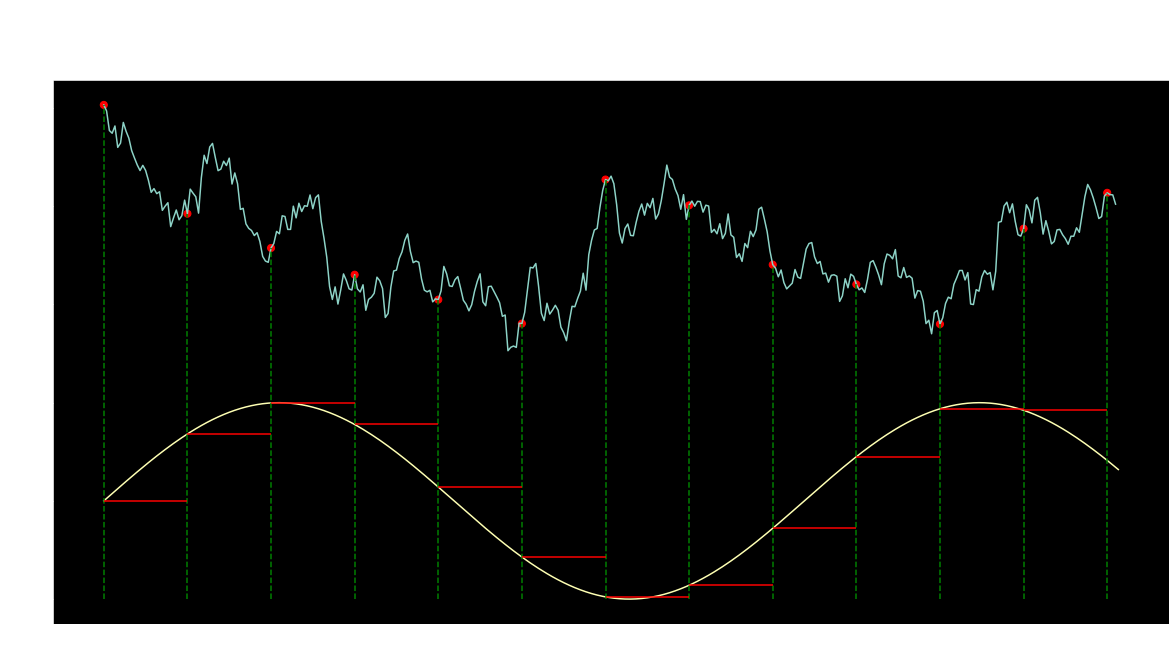

In [129]:
plt.figure(figsize=(20, 10))
plt.plot(Wt_+ 1)
plt.plot(foo)
plt.scatter(range(0,nday,dN), maximum, marker = 'o', color='red', s=50*np.ones_like(maximum))
plt.vlines(range(0,nday,dN), ymin= minimum, ymax = maximum, color = 'green', linestyles='--')
plt.hlines(foo[::dN][:-1], xmin=range(0,nday,dN)[:-1], xmax=range(0,nday,dN)[1:], color='red')
plt.xlabel('Time index', color='white', fontsize=20)
plt.ylabel('W(t);    b(t)', color='white', fontsize=20)
plt.title('Integration of b(t) by W(t):' + ' '*10+ '$I_N[b(t)] = \sum_{i=0}^{N-1} [W_{t_i} - W_{t_{i-1}}] \ b(t_{i-1})$', fontsize=25)
plt.show()

### 2.3 Stochastic Differential Equations (SDE)
Ito integral is used to build SDEs. We start from integral instead of differential because it is much easier to obtain integral for Brownian motion.
Actually, the notations
$$
\begin{aligned}
&\qquad I(t)=\int_0^t b(\tau) d W(\tau) \\
&\qquad d I(t)=b(t) d W(t) \\
\end{aligned}
$$

mean almost the same thing. First equation has the imprecise meaning that when we move forward a little bit in time
from time $t$, the change in the Itô integral $I$ is $b(t)$ times the change in the Brownian motion $W$. It also has a precise meaning, which one obtains by integrating both sides:

$$
\begin{aligned}
&\qquad I(t)=I(0)+\int_0^t b(\tau) d W(\tau)
\end{aligned}
$$
These equations mean exactly the same thing.

So when we see a Stochastic Differential Equation (diffusion proces for example)
$$
\text{d}\textbf{X}_t = \mu_t(t,\textbf{X}_t)\text{d}t + \sigma_t(t,\textbf{X}_t)\text{d}\textbf{W}_t
$$
We should think of it as this equation:
$$
\textbf{X}_t = \textbf{X}_0 + \int_0^T \mu_t(t,\textbf{X}_t)\text{d}t + \int_0^T \sigma_t(t,\textbf{X}_t)\text{d}\textbf{W}_t
$$

In general, we will consider $n$-dimensional diffusion processes $\textbf{X}_t$ over a probability space $\left( \Omega,  \mathbb{P} \right)$. The filtration $\mathcal{F}$ is generated by $m$ independent Wiener processes $\textbf{W}_t$. All auxiliary processes mentioned in those notes are assumed adapted to this filtration.

### 2.4 Ito Formula
Any non-degenerate correlation configuration can be reduced to the following SDE for $\textbf{X}_t$:
$$
\text{d}\textbf{X}_t = \mu_t(\textbf{X}_t)\text{d}t + \sigma_t(\textbf{X}_t)\text{d}\textbf{W}_t
$$
with $\mu_t$ an $n$-dimensional drift and $\sigma_t$ denoting a volatility $n \times m$-matrix. Well-posedness is established for Lipschitz bounds on $\mu_t$ and  $\sigma_t$.

Ito formula reads for $\textbf{Y}_t = f(t, \textbf{X}_t)$:
$$
\text{d}\textbf{Y}_t = \left( \frac{\partial f}{\partial t} + \mu_t^{*} \nabla_x f + \frac{1}{2} \text{tr} \left[ \sigma_t^{*} \cdot \nabla_x^2 f \cdot \sigma_t \right] \right) \text{d}t + \nabla_x^{*} f \cdot \sigma_t \text{d}\textbf{W}_t
$$

Conditional expectations:
$$
g(t, x) = \mathbb{E} \left[ h(\textbf{X}_T) | \textbf{X}_t=x \right]
$$
satisfy the Feynman-Kac equation:
$$
\frac{\partial g}{\partial t} + \mu_t^{*} \nabla_x g + \frac{1}{2} \text{tr} \left[ \sigma_t^{*} \cdot \nabla_x^2 g \cdot \sigma_t \right] = 0
$$
with initial condition $g(T, x) = h(x)$.

#### 2.4.1 Exercise: Feyman-Kac formula 
Derive the Feyman-Kac formula using the law of iterated expectations:
$$
\mathbb{E} \left[ h(\textbf{X}_T) | \mathcal{F}_s \right] = \mathbb{E} \left[ \mathbb{E} \left[ h(\textbf{X}_T) | \mathcal{F}_t \right] | \mathcal{F}_s \right]
$$
for $s \leq t$.

Transition probabilities:
$$
p(t,T,x,y) = \mathbb{P} \left( \textbf{X}_T = y | \textbf{X}_t = x \right)
$$
so that:
$$
g(t, x) = \int h(y)p(t,T,x,y)dy
$$
satisfy the Kolmogorov backward equation:
$$
\frac{\partial p}{\partial t} + \mu_t^{*} \nabla_x p + \frac{1}{2} \text{tr} \left[ \sigma_t^{*} \cdot \nabla_x^2 p \cdot \sigma_t \right] = 0
$$
with initial condition $p(t,t,x,y) = \delta(x-y)$.

## 2.5 Girsanov Theorem

We will discuss only a special case. Consider a process $\gamma_t$ with finite Ito norm $\int \gamma^2_t dt < \infty$. Associate to $\gamma_t$ the exponential process:
$$
\text{d}Z^{\gamma}_t = - Z_t \gamma_t \text{d}W_t, \quad Z_0=1
$$

We can use this process to define a new probability measure equivalent to $\mathbb{P}$:
$$
\text{d}\mathbb{Q}^\gamma = Z_T^{\gamma}\text{d}\mathbb{P}
$$

Girsanov showed that the process:
$$
\text{d}W^\gamma_t = \gamma_t\text{d}t + \text{d}W_t, \quad W^\gamma_0=0
$$
is a Wiener process under the measure $\mathbb{Q}^\gamma$.

### 2.6 Euler Scheme for SDEs

The simplest discretisation for $\textbf{X}_t$ over time steps $t_{i+1} = t_i + \Delta t$ compatible with Ito's integral is the explicit Euler scheme:
$$
\textbf{X}_{t_{i+1}}^{\Delta t} = \textbf{X}_{t_i}^{\Delta t} + \mu_t(\textbf{X}_{t_i}^{\Delta t})\Delta t + \sigma_t(\textbf{X}_{t_i}^{\Delta t}) \Delta t^{\frac{1}{2}}\Delta\textbf{W}
$$
where $\Delta\textbf{W}$ follows the standard normal distribution.

Strong convergence at some given time slice $t_i=T$ has asymptotics:
$$
\mathbb{E} \left( | \textbf{X}_T^{\Delta t} - \textbf{X}_T |^2 \right) = O(\Delta t)
$$
which is considerably worse than $O(\Delta t^2)$ for ODEs.

Weak convergence for the Monte-Carlo estimator:
$$
\textbf{V}^{\Delta t} =  \frac{1}{N} \sum_{k=0}^{N} \mathcal{P}(\textbf{X}_T^{\Delta t})
$$

of $\textbf{V} = \mathbb{E} \left[ \mathcal{P}(\textbf{X}_T) \right]$, for some payoff $\mathcal{P}$,  exhibits bias:
$$
\begin{split}
\text{MSE}(\textbf{V}^{\Delta t}) & =  \mathbb{E} \left[ \left( \textbf{V}^{\Delta t} - \textbf{V} \right)^2 \right] \\
 & =  \left( \mathbb{E} \left[\textbf{V}^{\Delta t}\right] - \textbf{V} \right)^2 + \mathbb{E} \left[ \left(\textbf{V}^{\Delta t} -\mathbb{E} \left[\textbf{V}^{\Delta t} \right] \right)^2 \right] \\
 & = \text{Bias}(\textbf{V}^{\Delta t})^2 + \text{Var}(\textbf{V}^{\Delta t}) \\
 & = O(\Delta t^2) + O(\frac{1}{N})
\end{split}
$$
beyond the central limit asymptotics.


### 2.7 Geometric Brownian Motion (GBM)

This is the simplest strictly positive process $S_t > 0$ with constant drift and volatility:
$$
\frac{\text{d}S_t}{S_t} = \mu \text{d}t + \sigma\text{d}W_t
$$
It's more convenient to work in log-space $Y_t = \log S_t$:
$$
\text{d}Y_t = \left(\mu - \frac{1}{2} \sigma^2\right)\text{d}t + \sigma\text{d}W_t
$$
from Ito's formula.

In [89]:
dt = torch.cat((torch.zeros(1), t.diff()))
num_paths = 1000
S0 = torch.tensor(100., requires_grad=True)
rate = 0.8
vol = torch.tensor(1.2, requires_grad=True)
Yt = ((rate - 0.5*vol**2)*dt + vol*torch.randn(num_paths, nday) * dt.sqrt()).cumsum(1) 
St = S0 * torch.exp(Yt)

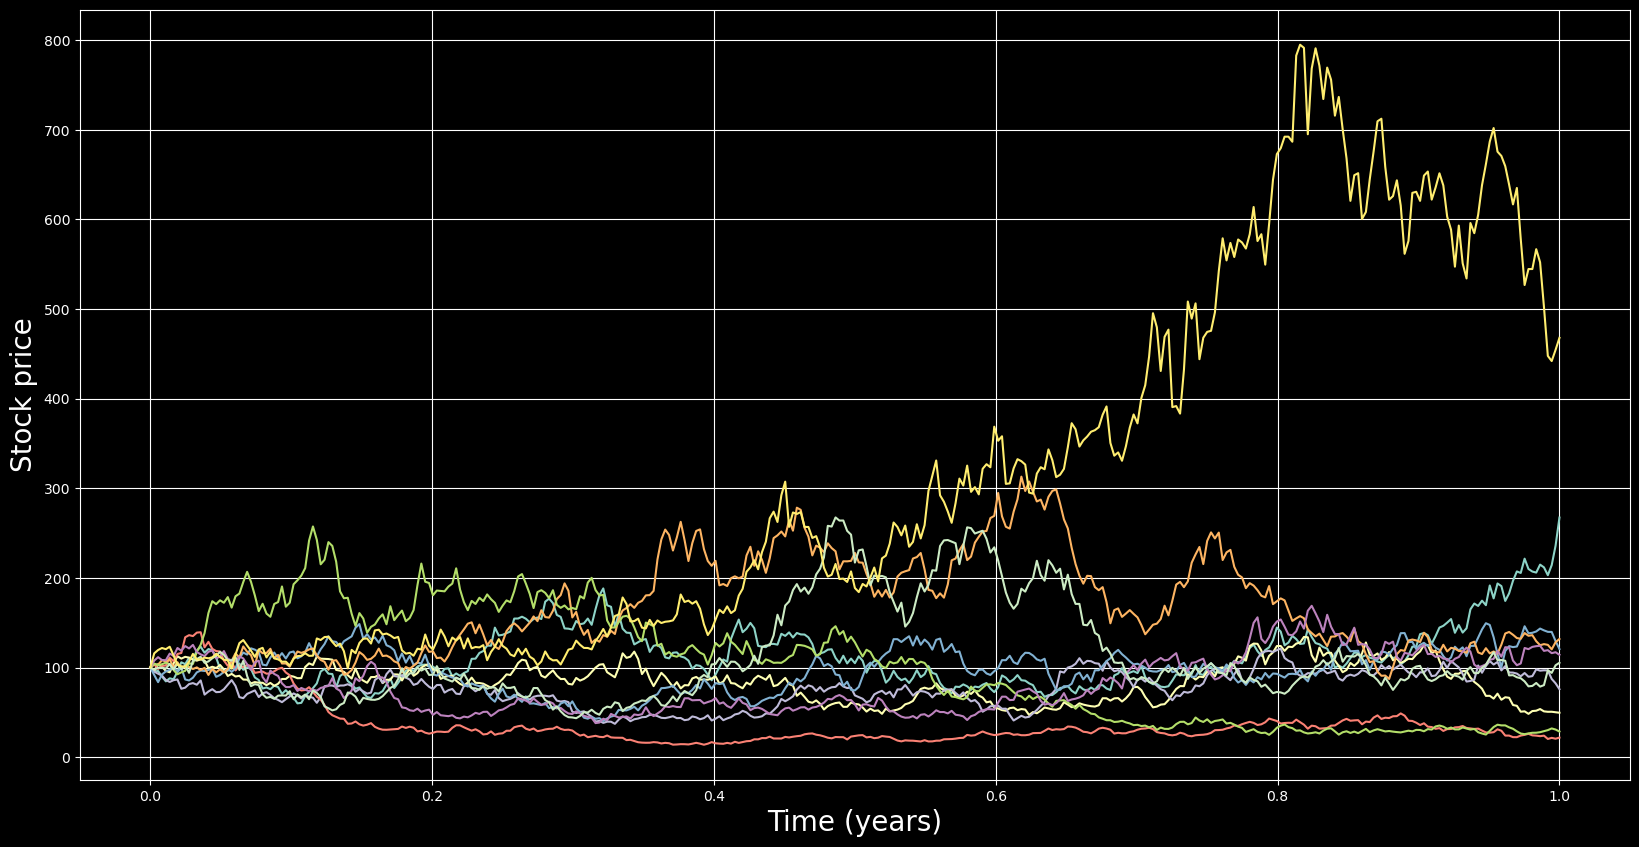

In [90]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), St[:10].detach().numpy().squeeze().T)
plt.xlabel('Time (years)', color='white', fontsize=20)
plt.ylabel('Stock price', color='white', fontsize=20)
plt.grid(True)
plt.show()

## 3 Risk-Neutral Valuation

Any pricing methodology should obey the no-arbitrage principle. 

### 3.1 Arbitrage
 An *arbitrage* is a trading strategy that starts from zero balance and has positive expected return with no probability of loss, i.e. a *risk-free strategy*.

Therefore, unless the no-abritrage condition is satisfied, we cannot talk about any notion of fair value.

#### 3.1.1 Pricing a Forward Contract

What is the present value $PV_F(t,T,K)$ of a contract at time $t$ that fixes its holder the price of the security $S_t$ to $K$ at some future time $T$?

It is essentially the present value of the forward contract where instead of using the forward rate $F(t,T)$ we have $K$. Therefore, we refer to such a contract as strike $K$ forward.

In fact the payoff at time $T$ is given by:
$$
PV_F(T,T,K) = S_T - K = \max\{S_T - K,0\} - \max\{K - S_T,0\}
$$
This decomposition immediately gives us:
$$
PV_F(t,T,K) = PV_C(t,T,K) - PV_P(t,T,K)
$$
where $PV_C(t,T,K)$ and $PV_P(t,T,K)$ are the present values at time $t$ of the European call and put options respectively with maturity $T$ and strike $K$.
On the other hand, we claim that:
$$
PV_F(t,T,K)  = P(t,T) \left(F(t,T) - K \right)
$$
This can be obtained by no-arbitrage arguments:

* if $PV_F(t,T,K_0) > P(t,T) \left(F(t,T) - K_0\right)$, for some strike $K_0$, we trade in the bond to finance the purchase of the security and stand as a writer in a forward contract at strike $K_0$:
$$
\frac{PV_F(t,T,K_0) - S_t}{P(t,T)} P(t,T) + S_t - PV_F(t,T,K_0) = 0
$$
which has no value at time $t$, but at time $T$ this portfolio is worth:
$$
\frac{PV_F(t,T,K_0) - S_t}{P(t,T)} + K_0 > 0
$$
which is a guaranteed win. That's arbitrage.
* if $PV_F(t,T,K_0) < P(t,T) \left(F(t,T) - K_0\right)$, we trade in the bond to finance the short sell of the security and buy a forward contract at strike $K_0$:
$$
\frac{S_t - PV_F(t,T,K_0)}{P(t,T)} P(t,T) - S_t + PV_F(t,T,K_0) = 0
$$
Again, this portfolio which has no value at time $t$, becomes:
$$
\frac{S_t - PV_F(t,T,K_0)}{P(t,T)} - K_0 > 0
$$
at time $T$ which is arbitrage.

Transaction costs and the risk of counter-party default are ignored in arbitrage arguments because we are only concerned with price dynamics.

#### Exercise 
Show that it costs nothing to enter the interest rate swap.

#### 3.1.2 Put-Call Parity

The previous example has lead to us to the identity:
$$
PV_C(t,T,K) - PV_P(t,T,K) = P(t,T) \left(F(t,T) - K \right)
$$
which is called the *put-call parity*. As a consequence, we get that the European ATM put and call have same value:
$$
PV_C(t,T,F(t,T)) = PV_P(t,T,F(t,T))
$$
Moreover, it costs nothing to enter a forward contract. But once purchased, the value of this contract will evolve according to $PV_F$.

### 3.2 Numeraire

We call a *numeraire* any basket of securities with a strictly positive value throughout time which is used as a denominator for all other securities. 

A typical example is the zero-coupon bond $P(t,T)$. In fact, prices denominated in $P(t,T)$ correspond to forward rates. 

However other numeraires can be more convenient, especially in interest rates. For swaps, it is natural to work with the annuity for example. 

Abusing terminology, we will call *forward prices* or simply *forwards* the prices of all securities denominated in some chosen numeraire. 

We always model forwards instead of the security prices directly. 

### 3.3  Risk Neutral Measure
The *risk-neutral measure*  $\mathbb{Q}^N$  w.r.t some chosen numeraire $N_t$ is defined to be the one under which the forward prices of all securities follow martingale dynamics. The measure $\mathbb{Q}^\gamma$  obtained from Girsanov's theorem in the BSM model is one basic example. 


#### 3.3.1 Stopping time
Let us denote by $\tau$ the stochastic process corresponding to the decision of the holder of the derivative contract to execute it. It is called the *stopping time*. In the case of American style options $\tau$ can take any value in the interval $[0,T]$, where $T$ is the maturity. For Bermudan style contracts the settlement dates are predetermined, and for European contracts the holder has no choice $\tau=T$. 

We will denote by $\mathcal{T}$ the set of all allowed stopping times.

#### 3.3.2 Risk Neutral Valuation
The forward price $FV$ of a derivative contract with (possbily path-dependent) payoff $\mathcal{P}$ is given by:
$$
FV_t= \max_{\tau \in \mathcal{T}} \mathbb{E}^N \left[ \mathcal{P}\left( \{f_s\}_{t \leq s \leq \tau} \right) | \mathcal{F}_t \right]
$$
and the present value is obtained after rescaling by the numeraire:
$$
PV_t = N_t FV_t
$$

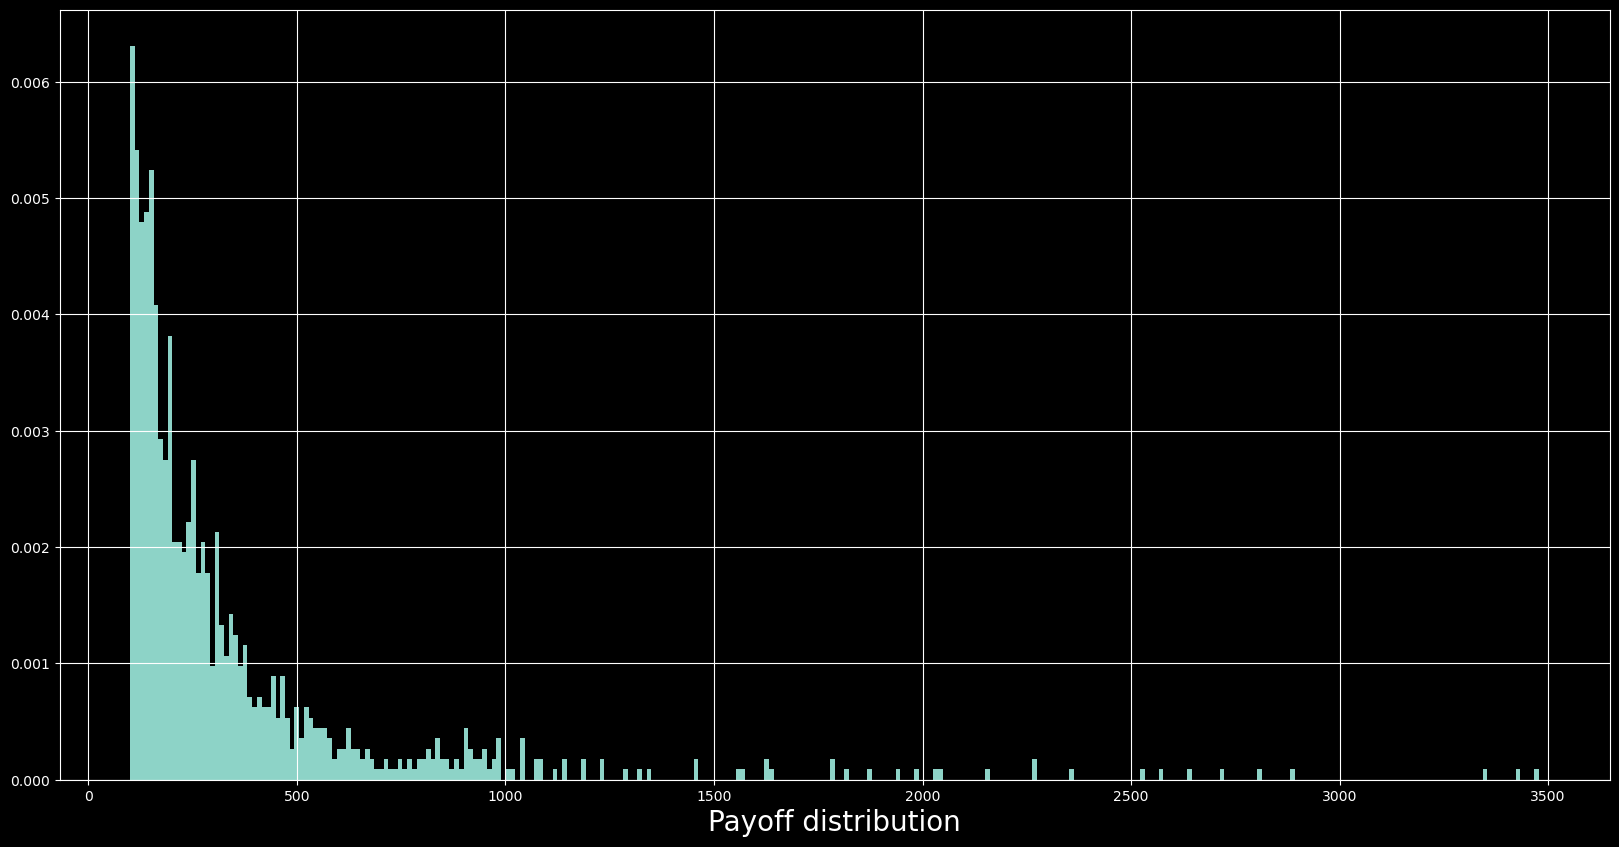

In [91]:
# Lookback option
payoff = torch.max(St,1).values
plt.figure(figsize=(20,10))
plt.hist(payoff.detach().numpy(), 300, density=True);
plt.xlabel('Payoff distribution', color='white', fontsize=20)
plt.grid(True)
plt.show()

In [92]:
PV = torch.exp(- rate * time_to_maturity[0]) * payoff.mean() # Forward Value
PV

tensor(158.2527, grad_fn=<MulBackward0>)

In [93]:
delta, kappa = torch.autograd.grad(PV, [S0, vol]) # reverse-mode automatic differentiation
print(f'Delta: {delta.item()}')
print(f'Kappa: {kappa.item()}')

Delta: 1.5825273990631104
Kappa: 76.95433044433594


## 4 Fundamental Theorem of Asset Pricing

A *complete market* is a market model where any derivative contract can be exactly replicated by trading in the underlying securities.  

The fundamental theorem of asset pricing states that in a complete market for a given numeraire there exist a risk-neutral measure which provides fair valuation for all securities. 

We will show that for Black=Scholes-Merton model this theorem holds, as special case of the Girsanov Theorem. However the assumtion of constant volatility is very restrictive.

In practice, exact replication is not interesting and so the notion of complete markets. What is important is the notion of risk neutral measure whose existence practitioners take for granted. 

### 4.1 Incomplete Markets
Several examples of *incomplete markets* are popular amongst trading desks:

#### Example 4.1.1: SABR model

This is the stochastic volatility model which describes the dynamics of the forward directly in the risk neutral measure:

$$
\begin{split}
\text{d}f_t & =  \sigma_t f_t^\beta \text{d}W_t^1   \\
\text{d}\sigma_t & =  \upsilon \sigma_t \left( \rho \text{d}W_t^1 + \sqrt{1-\rho^2} \text{d}W_t^2 \right) 
\end{split}
$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ CIR exponent and the Wiener processes are independent.

For $\beta < 1$, Girsanov's theorem does not apply and so it's not even clear how to build equivalent measures (without enriching the model with extra risk factors).  



#### Example 4.1.2: Heston model

Again, this is a stochastic volatility model for forward dynamics in the risk neutral measure:
$$
\begin{split}
\text{d}f_t & =  \sqrt{\sigma_t} f_t \text{d}W_t^1  \\
\text{d}\sigma_t & =  \kappa (\theta - \sigma_t) + \xi \sqrt{\sigma_t} \left( \rho \text{d}W_t^1 + \sqrt{1-\rho^2} \text{d}W_t^2 \right)  
\end{split}
$$

The vol correlation obeys $-1 < \rho < 1$  as previously, and we impose the Feller condition:
$$
2\kappa\theta > \xi ^2
$$
to ensure that the volatility $\sigma_t$ stays strictly positive.

For this model, Girsanov's theorem applies (exercise), however exact replication requires volatility swaps beyond the underlying forward. Not many markets for such products exists yet.

## References

* Seydel, R.U. *Tools for Computational Finance*, 6th edition, Springer V., London (2017)
* Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)
* Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)
* Savine, A. Modern Computational Finance: AAD and Parallel Simulations, Wiley (2018)